# Lasso, Ridge and Elastic Net Regressions

This notebook presents a simple implementation of Lasso and elastic net regressions.

## Load Packages and Extra Functions

In [1]:
using DelimitedFiles, LinearAlgebra, Statistics, Plots, Convex, SCS

In [2]:
include("ops.jl")

findmax (generic function with 8 methods)

# Loading Data

We use the diabetes data from Efron et al, downloaded from https://web.stanford.edu/~hastie/StatLearnSparsity_files/DATA/diabetes.html and then converted from a tab to a comma delimited file.

All data series are standardised (see below) to have zero means and unit standard deviation, which improves the numerical stability. (Efron et al do not standardise the scale of the response variable.)

In [3]:
(x, header) = readdlm("data/diabetes.csv", ',', header = true)
# display(header)
# display(x)

x = (x .- mean(x, dims = 1)) ./ std(x, dims = 1)          #standardise

(Y, X) = (x[:, end], x[:, 1:end-1]);                  #to get traditional names
xNames = header[1:end-1];

# Lasso, Ridge and Elastic Net Regressions

(a)  The regression is $Y = Xb + u$,
where $Y$ and $u$ are $T \times 1$, $X$ is $T \times K$, and $b$ is the $K$-vector of regression coefficients.

(b) We want to minimize $(Y-Xb)'(Y-Xb)/T + \gamma \sum |b_i| + \lambda \sum b_i^2$.

(c) We can equally well minimise $b'Qb - 2c'b + \gamma \sum |b_i| + \lambda \sum b_i^2$,
where $Q = X'X/T$ and $c=X'Y/T$.

(d) Lasso: $\gamma>0,\lambda=0$; Ridge: $\gamma=0,\lambda>0$; elastic net: $\gamma>0,\lambda>0$.

In [4]:
"""
    LassoEN(Y,X,γ,λ)

Do Lasso (set γ>0,λ=0), ridge (set γ=0,λ>0) or elastic net regression (set γ>0,λ>0).


# Input
- `Y::Vector`:     T-vector with the response (dependent) variable
- `X::VecOrMat`:   TxK matrix of covariates (regressors)
- `γ::Number`:     penalty on sum(abs.(b))
- `λ::Number`:     penalty on sum(b.^2)

"""
function LassoEN(Y, X, γ, λ = 0)
    (T, K) = (size(X, 1), size(X, 2))

    b_ls = X \ Y                    #LS estimate of weights, no restrictions

    Q = (X)ᵀ*X / T
    c = (X)ᵀ*Y / T                      #c'b = Y'X*b

    b = Variable(K)              #define variables to optimize over
    L1 = quadform(b, Q)            #b'Q*b
    L2 = dot(c, b)                 #c'b
    L3 = norm(b, 1)                #sum(|b|)
    L4 = sumsquares(b)            #sum(b^2)

    if λ > 0
        Sol = minimize(L1 - 2 * L2 + γ * L3 + λ * L4)      #u'u/T + γ*sum(|b|) + λ*sum(b^2), where u = Y-Xb
    else
        Sol = minimize(L1 - 2 * L2 + γ * L3)               #u'u/T + γ*sum(|b|) where u = Y-Xb
    end
    solve!(Sol, SCS.Optimizer; silent_solver = true)
    Sol.status == Convex.MOI.OPTIMAL ? b_i = vec(evaluate(b)) : b_i = NaN

    return b_i, b_ls
end

LassoEN

The next cell makes a Lasso regression for a single value of γ.

In [5]:
K = size(X, 2)
γ = 0.25

(b, b_ls) = LassoEN(Y, X, γ)

println("OLS and Lasso coeffs (with γ=$γ)")
display([["" "OLS" "Lasso"]; xNames b_ls b])

OLS and Lasso coeffs (with γ=0.25)


11×3 Matrix{Any}:
 ""       "OLS"        "Lasso"
 "AGE"  -0.00618293   8.28707e-5
 "SEX"  -0.14813      5.65438e-5
 "BMI"   0.3211       0.295132
 "BP"    0.200367     0.091037
 "S1"   -0.489314     0.000171273
 "S2"    0.294474     0.000187834
 "S3"    0.0624127   -0.042918
 "S4"    0.109369     9.97689e-5
 "S5"    0.464049     0.255667
 "S6"    0.0417719    0.000106045

# Redo the Lasso Regression with Different Gamma Values


We now loop over $\gamma$ values.

Remark: it would be quicker to put this loop inside the `LassoEN()` function so as to not recreate `L1`-`L4`.

In [6]:
nᵧ = 101
γₘ = range(0; stop = 1.5, length = nᵧ)             #different γ values

bₗₐₛₛₒ = fill(NaN, size(X, 2), nᵧ)       #results for γM[i] are in bLasso[:,i]
for i in 1:nᵧ
    sol, _ = LassoEN(Y, X, γₘ[i])
    bₗₐₛₛₒ[:, i] .= sol
end

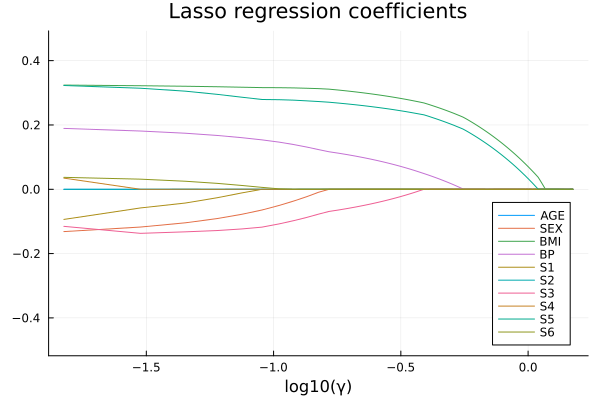

In [7]:
plot(
    log10.(γₘ),
    (bₗₐₛₛₒ)ᵀ,
    title = "Lasso regression coefficients",
    xlabel = "log10(γ)",
    label = permutedims(xNames),
    size = (600, 400),
)

# Ridge Regression

We use the same function to do a ridge regression. Alternatively, do `b = inv(X'X/T + λ*I)*X'Y/T`.

In [8]:
nλ = 101
γₘ = range(0; stop = 7.5, length = nλ)

bᵣᵢᵨₚₑ = fill(NaN, size(X, 2), nλ)
for i in 1:nλ
    sol, _ = LassoEN(Y, X, 0, γₘ[i])
    bᵣᵢᵨₚₑ[:, i] .= sol
end

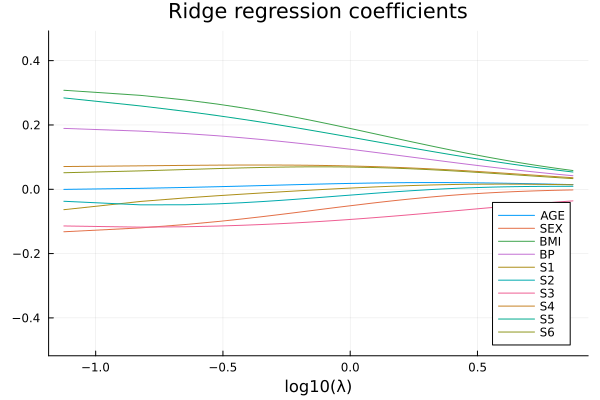

In [9]:
plot(
    log10.(γₘ),
    (bᵣᵢᵨₚₑ)ᵀ,
    title = "Ridge regression coefficients",
    xlabel = "log10(λ)",
    label = permutedims(xNames),
    size = (600, 400),
)

# Elastic Net Regression

In [10]:
λ = 0.5
println("redo the Lasso regression, but with λ=$λ: an elastic net regression")

bₑₙ = fill(NaN, size(X, 2), nᵧ)
for i in 1:nᵧ
    sol, _ = LassoEN(Y, X, γₘ[i], λ)
    bₑₙ[:, i] .= sol
end

redo the Lasso regression, but with λ=0.5: an elastic net regression


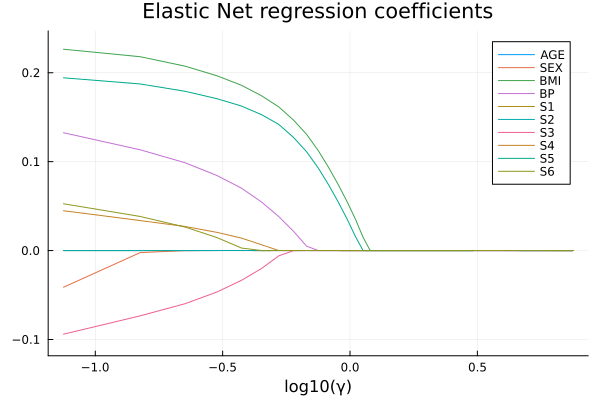

In [11]:
plot(
    log10.(γₘ),
    (bₑₙ)ᵀ,
    title = "Elastic Net regression coefficients",
    xlabel = "log10(γ)",
    label = permutedims(xNames),
    size = (600, 400),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*

# References
- [ ] [Lasso, Ridge and Elastic Net Regressions](https://jump.dev/Convex.jl/stable/examples/general_examples/lasso_regression/)
- [ ] [Regularization Part 1: Ridge (L2) Regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
- [ ] [Regularization Part 2: Lasso (L1) Regression](https://www.youtube.com/watch?v=NGf0voTMlcs)
- [ ] [Regularization Part 3: Elastic Net Regression](https://www.youtube.com/watch?v=1dKRdX9bfIo)